# Fonction prediction arguments: test_set, features, categorical features



In [ ]:
def predict(test_set,columns1,categoric):


  # Encoding categorical variables in test
  def preprocess_test(test_set):
    df2 = test_set[columns1]
    df2 = pd.get_dummies(df2, columns=categoric, prefix=categoric)
    df2 = df2.select_dtypes(exclude=['datetime64','object'])
    columns = X_train.columns
    df2 = df2.reindex(columns=columns, fill_value=0)
    df2 = df2[columns]
    return(df2)


  # Eliminate nan values in train
  traain = train2.copy()
  traain = traain.dropna(subset=['Qté eau (m3)','N','P','K','year_plantage','sup totale'])   #no nan values in train


  # Encoding categorical variables in train
  from sklearn.preprocessing import OneHotEncoder
  df = traain[columns1]
  df['Tonnage'] = traain['Tonnage']
  df_onehot = pd.get_dummies(df, columns=categoric, prefix=categoric)
  df = df_onehot.loc[:, df_onehot.columns != 'Tonnage']
  df['Tonnage'] = df_onehot['Tonnage']
  df = df.select_dtypes(exclude=['datetime64','object'])


  # Eliminate outliers
  from scipy import stats
  y = df['Tonnage']
  X = df.drop('Tonnage', axis=1)
  z_scores = stats.zscore(X)
  abs_z_scores = np.abs(z_scores)
  filtered_entries = (abs_z_scores < 2).all(axis=1)
  if X[filtered_entries].shape[0] > 0:
    X = X[filtered_entries]
  X.insert(len(X.columns), 'Tonnage', y)
  df = X


  # Scaling
  from sklearn.preprocessing import MinMaxScaler
  y = df['Tonnage']
  X = df.drop('Tonnage', axis=1)
  scaler = MinMaxScaler()
  data_without_tonnage = pd.DataFrame(scaler.fit_transform(X), index=y.index)
  data_without_tonnage.columns = X.columns
  data_without_tonnage.insert(len(data_without_tonnage.columns), 'Tonnage', y)
  df = data_without_tonnage
  y = df['Tonnage']
  X = df.drop('Tonnage', axis=1)


  # Splitting the dataset
  X = df.drop('Tonnage', axis=1)
  y = df['Tonnage']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


  # Indicators
  def mean_absolute_percentage_error(y_true, y_pred):
      y_true, y_pred = np.array(y_true), np.array(y_pred)
      return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  from sklearn.metrics import mean_squared_error, mean_absolute_error
  def mean_absolute_error(y_true, y_pred):
      return mean_absolute_error(y_true, y_pred)

  # Plotting the results
  import matplotlib.pyplot as plt
  from scipy.stats import linregress

  def plot_regression_results(ax, y_test, y_pred, title, estimated_time, scores):

    # linear least-squares
    slope, intercept, rvalue, pvalue, stderr = linregress(y_test, y_pred)
    ax.plot([y_test.min(), y_test.max()], [intercept+y_test.min()*slope, intercept+y_test.max()*slope], '--r')

    ax.scatter(y_test, y_pred, alpha=0.7)

    # Anzeigen der Werte in einer Box
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                            edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')

    ax.set_xlabel('Actual values')
    ax.set_ylabel('Predictes values')
    ax.set_title('{}\nTrained in {:.2f} Milliseconds'.format(name, estimated_time*1000))

  # Regression models
  from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error
  from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
  from sklearn.linear_model import LinearRegression, SGDRegressor
  from sklearn.model_selection import train_test_split
  from sklearn.neighbors import KNeighborsRegressor
  from sklearn.tree import DecisionTreeRegressor
  import time

  lin = LinearRegression()
  dtr = DecisionTreeRegressor()
  sgd = SGDRegressor(loss='squared_error')
  gbr = GradientBoostingRegressor()
  knn = KNeighborsRegressor(n_neighbors=5)
  rfr = RandomForestRegressor()
  # Regressions used
  estimators = [('Linear Regression', lin),
                ('Decision Tree Regression', dtr),
                ('Stochastic Gradient Descent Regression', sgd),
                ('Gradient Boosting Regression', gbr),
                ('K-nearest Neighbour 5', knn),
                ('Random Forest Regression', rfr)]
  # Define the subplots
  fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(20, 13))
  axs = np.ravel(axs)
  L = []
  test_set = preprocess_test(test_set)
  columns = X_train.columns
  test_set = test_set[columns]

  for ax, (name, est) in zip(axs, estimators):
    start_time = time.time()
    # Training the model
    est.fit(X_train, y_train)
    y_pred = est.predict(X_test)
    y_pred_test = est.predict(test_set)
    L.append([name,test_set,y_pred_test])
    estimated_time = time.time() - start_time

    # Visualize the model
    plot_regression_results(ax, y_test, y_pred, name, estimated_time,
                            (r'$R^2$ = {:.2f}' + '\n' +
                            r'MAE = {:.0f}' + '\n' +
                            r'MSE = {:.0f}' + '\n' +
                            r'RMSE = {:.0f}' + '\n' +
                            r'MAX = {:.0f}' + '\n' +
                            r'MAPE = {:.2f}%')
                            .format(r2_score(y_test, y_pred),
                                    mean_absolute_error(y_test, y_pred),
                                    mean_squared_error(y_test, y_pred),
                                    mean_squared_error(y_test, y_pred, squared=False),
                                    max_error(y_test, y_pred),
                                    mean_absolute_percentage_error(y_test, y_pred)))

  plt.suptitle('Regressionsverfahren')
  plt.tight_layout()
  plt.subplots_adjust(top=0.9)
  plt.show()

  #L = list(Model,test_set,predictions)
  return(L)

# Other imports


In [ ]:
import pandas as pd
import numpy as np
import missingno as msno
from tqdm import tqdm
from datetime import timedelta
import random



In [ ]:
# @title
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import apports NPK, irrigations..


In [ ]:
# Import apports NPK
dfs = []
for k in [10, 11, 12]:
  df = pd.read_csv(f"/content/drive/MyDrive/Projet kaggle/Apports N.P.K_{k}.csv", delimiter=";", encoding="latin-1")
  dfs.append(df)
Apports = pd.concat(dfs, axis=0)

# Import irrigations
dfs = []
for k in range(2, 10):
  df = pd.read_csv(f"/content/drive/MyDrive/Projet kaggle/Irrigation_{k}.csv", delimiter=";", encoding="latin-1")
  dfs.append(df)
irrigation = pd.concat(dfs, axis=0)


In [ ]:
#Import train, test, Parcellaire
train = pd.read_csv("/content/drive/MyDrive/Projet kaggle/train.csv", delimiter=";", encoding="latin-1")
test  = pd.read_csv("/content/drive/MyDrive/Projet kaggle/test.csv", delimiter=";", encoding="latin-1")
Parcellaire = pd.read_csv("/content/drive/MyDrive/Projet kaggle/Parcellaire_1.csv", delimiter=";", encoding="latin-1")


In [ ]:
# Preprocessing (str to float,Bengu\?rir => Benguérir, drop nan, date to datetime)
for col in ['N', "P", "K"]:
  Apports[col] = Apports[col].str.replace(",", ".").astype(float)
irrigation["Qté eau (m3)"] = irrigation["Qté eau (m3)"].str.replace(",", ".").str.replace("?", "").astype(float)
train["Tonnage"] = train["Tonnage"].str.replace(",", ".").astype(float)


train['Site'] = train['Site'].replace('Bengu\?rir', 'Benguérir', regex=True)
Apports['Site'] = Apports['Site'].replace('Bengu\?rir', 'Benguérir', regex=True)
test['Site'] = test['Site'].replace('Bengu\?rir', 'Benguérir', regex=True)
irrigation['Site'] = irrigation['Site'].replace('Bengu\?rir', 'Benguérir', regex=True)

Apports = Apports.dropna(subset=['Campagne','Site','Num Parcelle'])
irrigation = irrigation.dropna(subset=['Campagne','Site','Num Parcelle'])

Apports["Date"] = pd.to_datetime(Apports["Date"])
train["Date"] = pd.to_datetime(train["Date"])
test["Date"] = pd.to_datetime(test["Date"])

<ipython-input-1111-5f9c5a65c79e>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  irrigation["Qté eau (m3)"] = irrigation["Qté eau (m3)"].str.replace(",", ".").str.replace("?", "").astype(float)


# Preprocess

In [ ]:
# Preprocess train
columns_to_remove = ['Id','CodeTracabilite' , 'Date' ]
train2 = train.copy()
train2 = train2.drop(columns=columns_to_remove)

train2['num'] = train2['Site'] + train2['Num Parcelle'].astype(str).str.replace(r'(\s|\.0)$', '', regex=True) + train2['Variete'].str.replace(' ', '')
train2['num'] = train2['num'].replace('\.0$', '', regex=True)
train2 = train2.sort_values(by='num')

In [ ]:
# Create column counter (nb of harvest months per year)
# Group by 'campagne' and 'num', count the duplicates, and calculate the mean
train2['counter'] = train2.groupby(['Campagne','num'])['num'].transform('count')
# # Calculate mean_counter for each num

train2 = train2.drop_duplicates(subset=['Campagne', 'num'], keep='first')

mean_counter_by_num = train2[train2['Campagne'].isin(['20/21', '21/22'])].groupby('num')['counter'].sum().reset_index()
mean_counter_by_num['counter'] = mean_counter_by_num['counter'] / 2
mean_counter_by_num['counter'] = mean_counter_by_num['counter'].apply(lambda x: 2.5 if x < 2.5 else x)


# # Merge mean_counter_by_num with train3 on 'num'
train2 = pd.merge(train2, mean_counter_by_num, on='num', how='left', suffixes=('', '_mean'))

# # Rename the 'counter' column to 'mean_n'
train2.rename(columns={'counter': 'mean_n'}, inplace=True)


In [ ]:
# Sum tonnage on year => add column Tonnage_sum

# Calculate the sum of 'Tonnage' for each 'num' grouped by 'Campagne'
sum_tonnage_per_num = train2.groupby(['Campagne', 'num'])['Tonnage'].sum().reset_index()
# Drop the 'Tonnage' column
train2 = train2.drop(columns=['Tonnage'])

# Merge the 'sum_tonnage_per_num' DataFrame with 'train2' on 'Campagne' and 'num'
train2 = pd.merge(train2, sum_tonnage_per_num, on=['Campagne', 'num'], how='left', suffixes=('', '_sum'))

# Rename the 'Tonnage_sum' column to 'sumtonnage'
train2 = train2.rename(columns={'Tonnage': 'Tonnage_sum'})
train2 = train2.drop_duplicates()
train2 = train2.sort_values(by='num')

In [ ]:
# Sum annual irrigation

# Add a new column 'num' by concatenating 'Site' and 'Num Parcelle'
irrigation['num'] = irrigation['Site'] + irrigation['Num Parcelle'].astype(str).str.replace(r'(\s|\.0)$', '', regex=True) + irrigation['Variete'].str.replace(' ', '')

irrigation['num'] = irrigation['num'].replace('\.0$', '', regex=True)


# Remove specified columns
columns_to_remove = ['Region', 'Site', 'Famille', 'Variete', 'Num Parcelle', 'Code Traçabilité', 'Date']
irrigation = irrigation.drop(columns=columns_to_remove)

# Groupby with loading meter
sum_values_per_num = irrigation.groupby(['Campagne', 'num'])[['Qté eau (m3)']].sum().reset_index()
irrigation = irrigation.drop(columns=['Qté eau (m3)'])

# Merge the calculated sum values back into the original DataFrame

irrigation = pd.merge(irrigation, sum_values_per_num, on=['Campagne', 'num'], how='left', suffixes=('', '_sum'))
irrigation = irrigation.drop_duplicates()
irrigation = irrigation.sort_values(by='num')

train2 = pd.merge(train2, irrigation, on=['Campagne', 'num'], how='left')


In [ ]:
# sum apports npk annual

# Add a new column 'num' by concatenating 'Site' and 'Num Parcelle'
Apports['num'] = Apports['Site'] + Apports['Num Parcelle'].astype(str).str.replace(r'(\s|\.0)$', '', regex=True) + Apports['Variete'].str.replace(' ', '')
Apports['num'] = Apports['num'].replace('\.0$', '', regex=True)


# Remove specified columns
columns_to_remove = ['Region', 'Site', 'Famille', 'Variete', 'Num Parcelle', 'CodeTracabilite', 'Date']
Apports = Apports.drop(columns=columns_to_remove)

# Calculate the sum of 'N', 'P', 'K' for each 'num' grouped by 'Campagne'
sum_values_per_num = Apports.groupby(['Campagne', 'num'])[['N', 'P', 'K']].sum().reset_index()

# Remove columns 'N', 'P', 'K'
Apports = Apports.drop(columns=['N', 'P', 'K'])

# Merge the calculated sum values back into the original DataFrame
Apports = pd.merge(Apports, sum_values_per_num, on=['Campagne', 'num'], how='left', suffixes=('', '_sum'))
Apports = Apports.drop_duplicates()

Apports = Apports.sort_values(by='num')

# Display the updated DataFrame
Apports.to_csv('/content/drive/MyDrive/Projet kaggle/apports2.csv', index=False)


train2 = pd.merge(train2, Apports, on=['Campagne', 'num'], how='left')

In [ ]:
# Preprocess test set

columns_to_remove = ['Id','CodeTracabilite' , 'Date' ]


# Remove the specified columns
test2 = test.copy()
test2 = test2.drop(columns=columns_to_remove)
test2.to_csv('/content/drive/MyDrive/Projet kaggle/test2.csv', index=False)



test2['num'] = test2['Site'] + test2['Num Parcelle'].astype(str).str.replace(r'(\s|\.0)$', '', regex=True) + test2['Variete'].str.replace(' ', '')
test2['num'] = test2['num'].replace('\.0$', '', regex=True)

# Display the updated DataFrame

test2 = pd.merge(test2, irrigation, on=['Campagne', 'num'], how='left')
test2 = pd.merge(test2, Apports, on=['Campagne', 'num'], how='left')
test2 = test2.drop_duplicates()


In [ ]:
# Preprocess Parcellaire
# Add a new column 'num' by concatenating 'Site' and 'Num Parcelle'
Parcellaire['num'] = Parcellaire['Site'] + Parcellaire['Num Parcelle'].astype(str).str.replace(r'(\s|\.0)$', '', regex=True) + Parcellaire['Variete'].str.replace(' ', '')
Parcellaire['num'] = Parcellaire['num'].replace('\.0$', '', regex=True)

#simplification:
Parcellaire = Parcellaire.drop_duplicates(subset=['Campagne','num'])


Parcellaire['sup totale']= Parcellaire['Sup Debut Camp'].str.replace(",", ".").astype(float) + Parcellaire['Sup Plantee'].str.replace(",", ".").astype(float) - Parcellaire['Sup Plantee'].str.replace(",", ".").astype(float)
Parcellaire['Date Plantation'] = pd.to_datetime(Parcellaire['Date Plantation'])

# Extracting the year
Parcellaire['year_plantage'] = Parcellaire['Date Plantation'].dt.year

# Merge the two DataFrames
test2 = pd.merge(test2 ,Parcellaire[['Campagne', 'num','Porte Greffe','sup totale','year_plantage']], on=['Campagne', 'num'], how='left')
train2 = pd.merge(train2 ,Parcellaire[['Campagne','Porte Greffe','num','sup totale','year_plantage']], on=['Campagne', 'num'], how='left')

<ipython-input-1122-eec5f4082d82>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Parcellaire['sup totale']= Parcellaire['Sup Debut Camp'].str.replace(",", ".").astype(float) + Parcellaire['Sup Plantee'].str.replace(",", ".").astype(float) - Parcellaire['Sup Plantee'].str.replace(",", ".").astype(float)
<ipython-input-1122-eec5f4082d82>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Parcellaire['Date Plantation'] = pd.to_datetime(Parcellaire['Date Plantation'])
<ipython-input-1122-eec5f4082d82>:15: Set

# Modeling and plotting the results

<ipython-input-1195-d2e6f05b5051>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tonnage'] = traain['Tonnage']


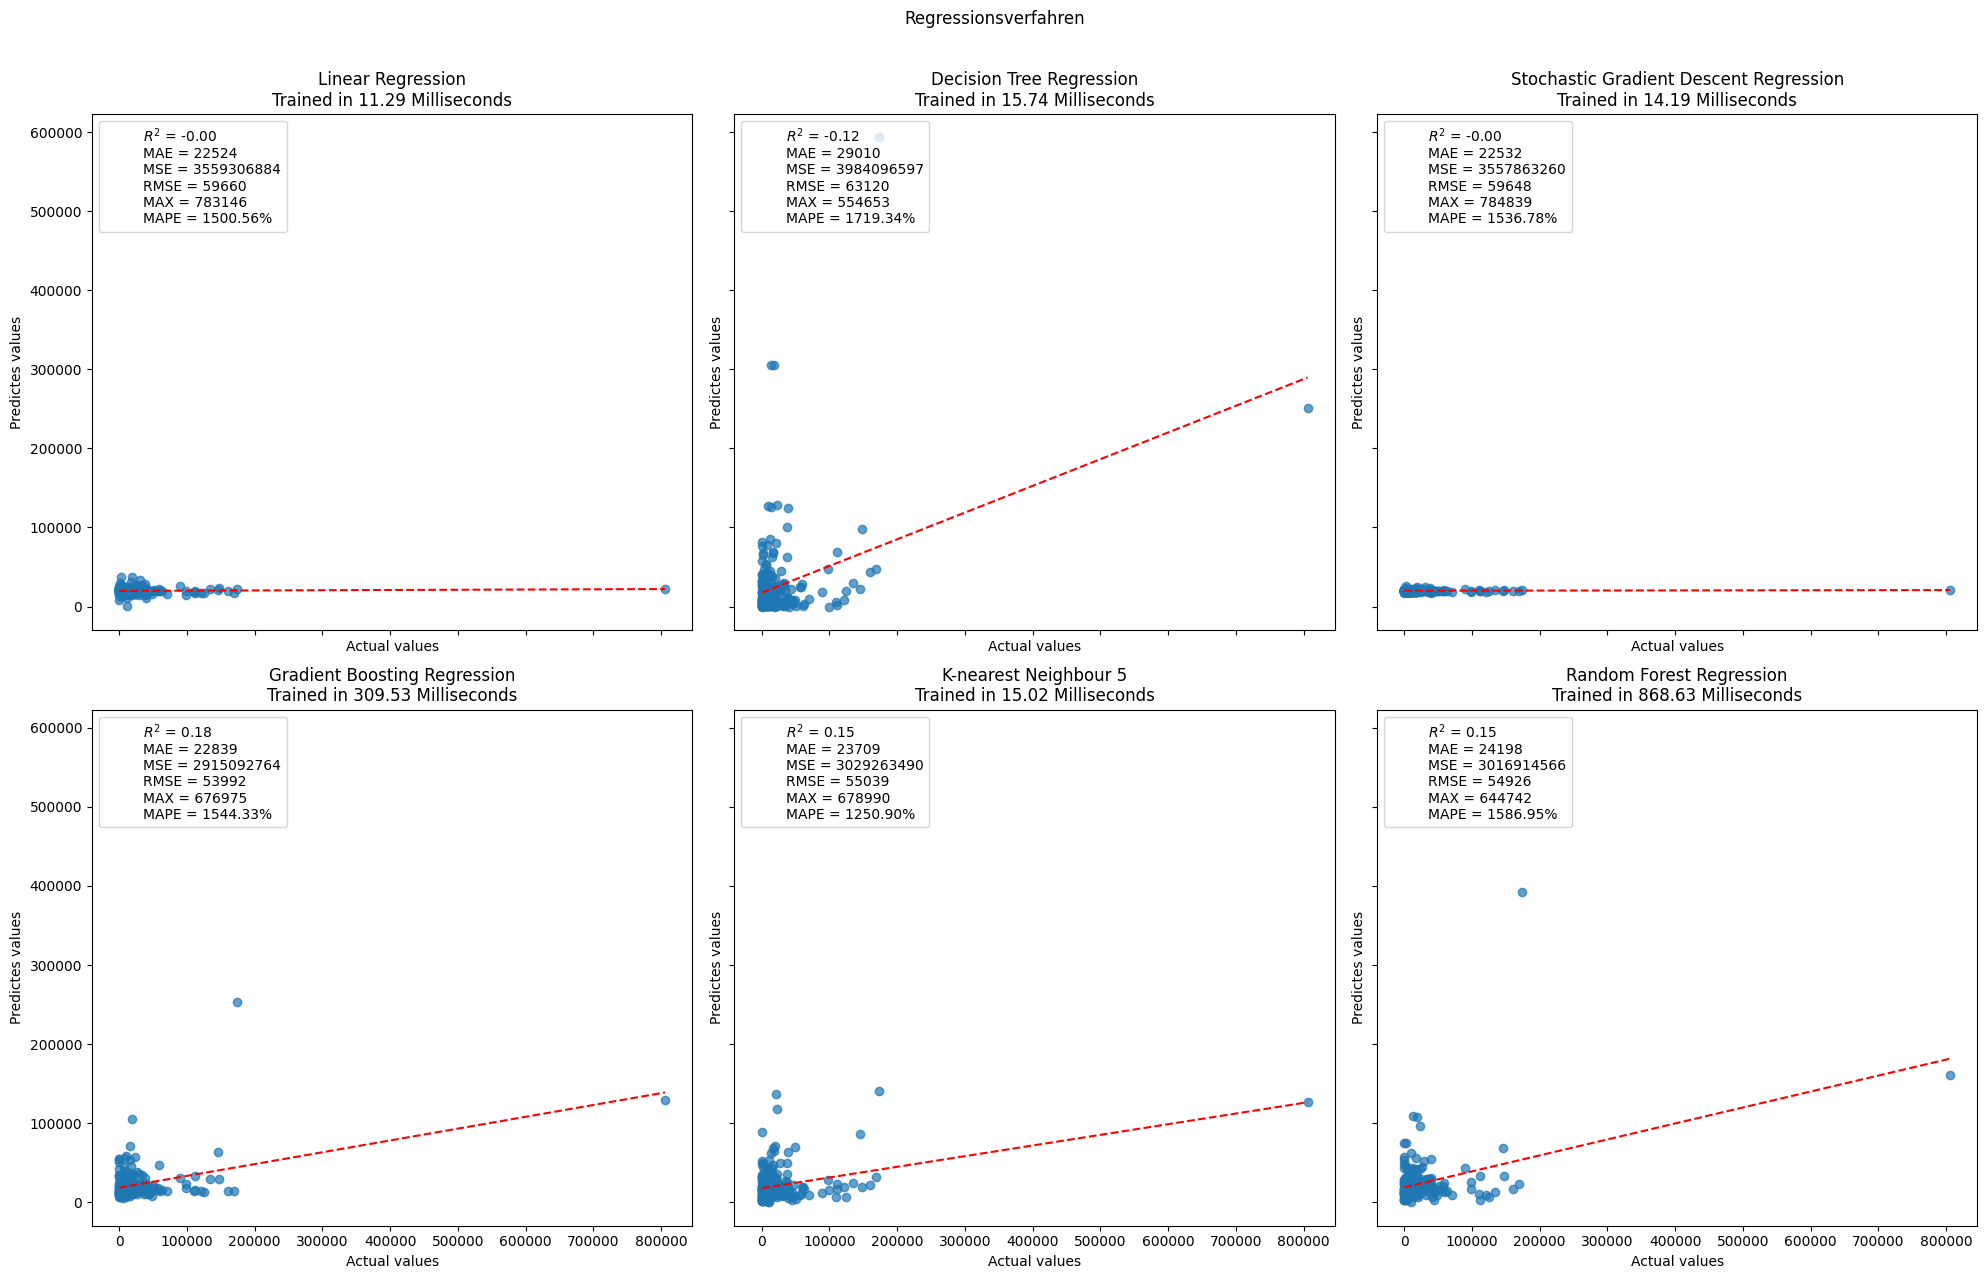

<ipython-input-1195-d2e6f05b5051>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tonnage'] = traain['Tonnage']


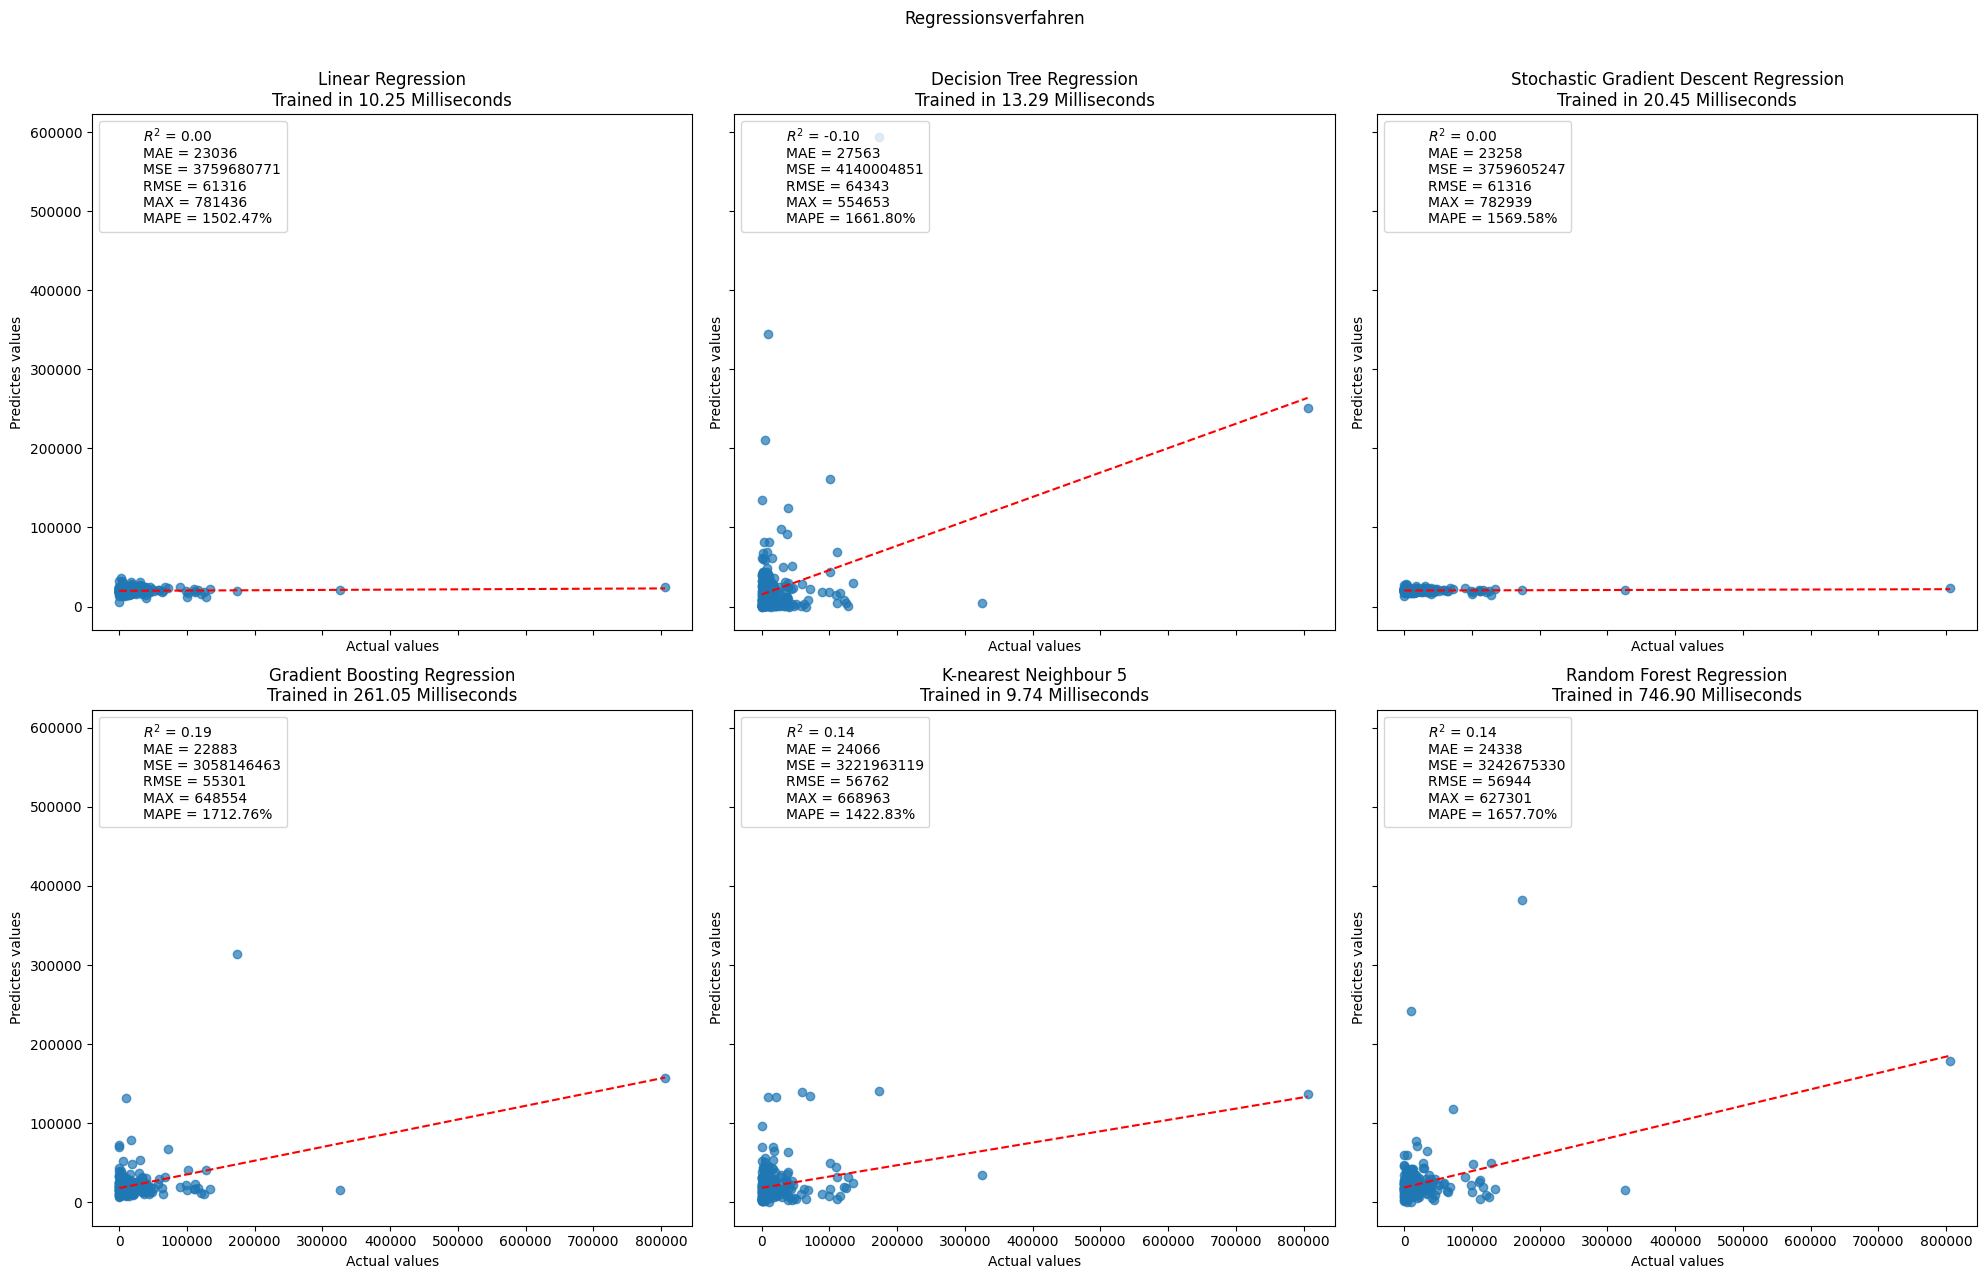

<ipython-input-1195-d2e6f05b5051>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tonnage'] = traain['Tonnage']


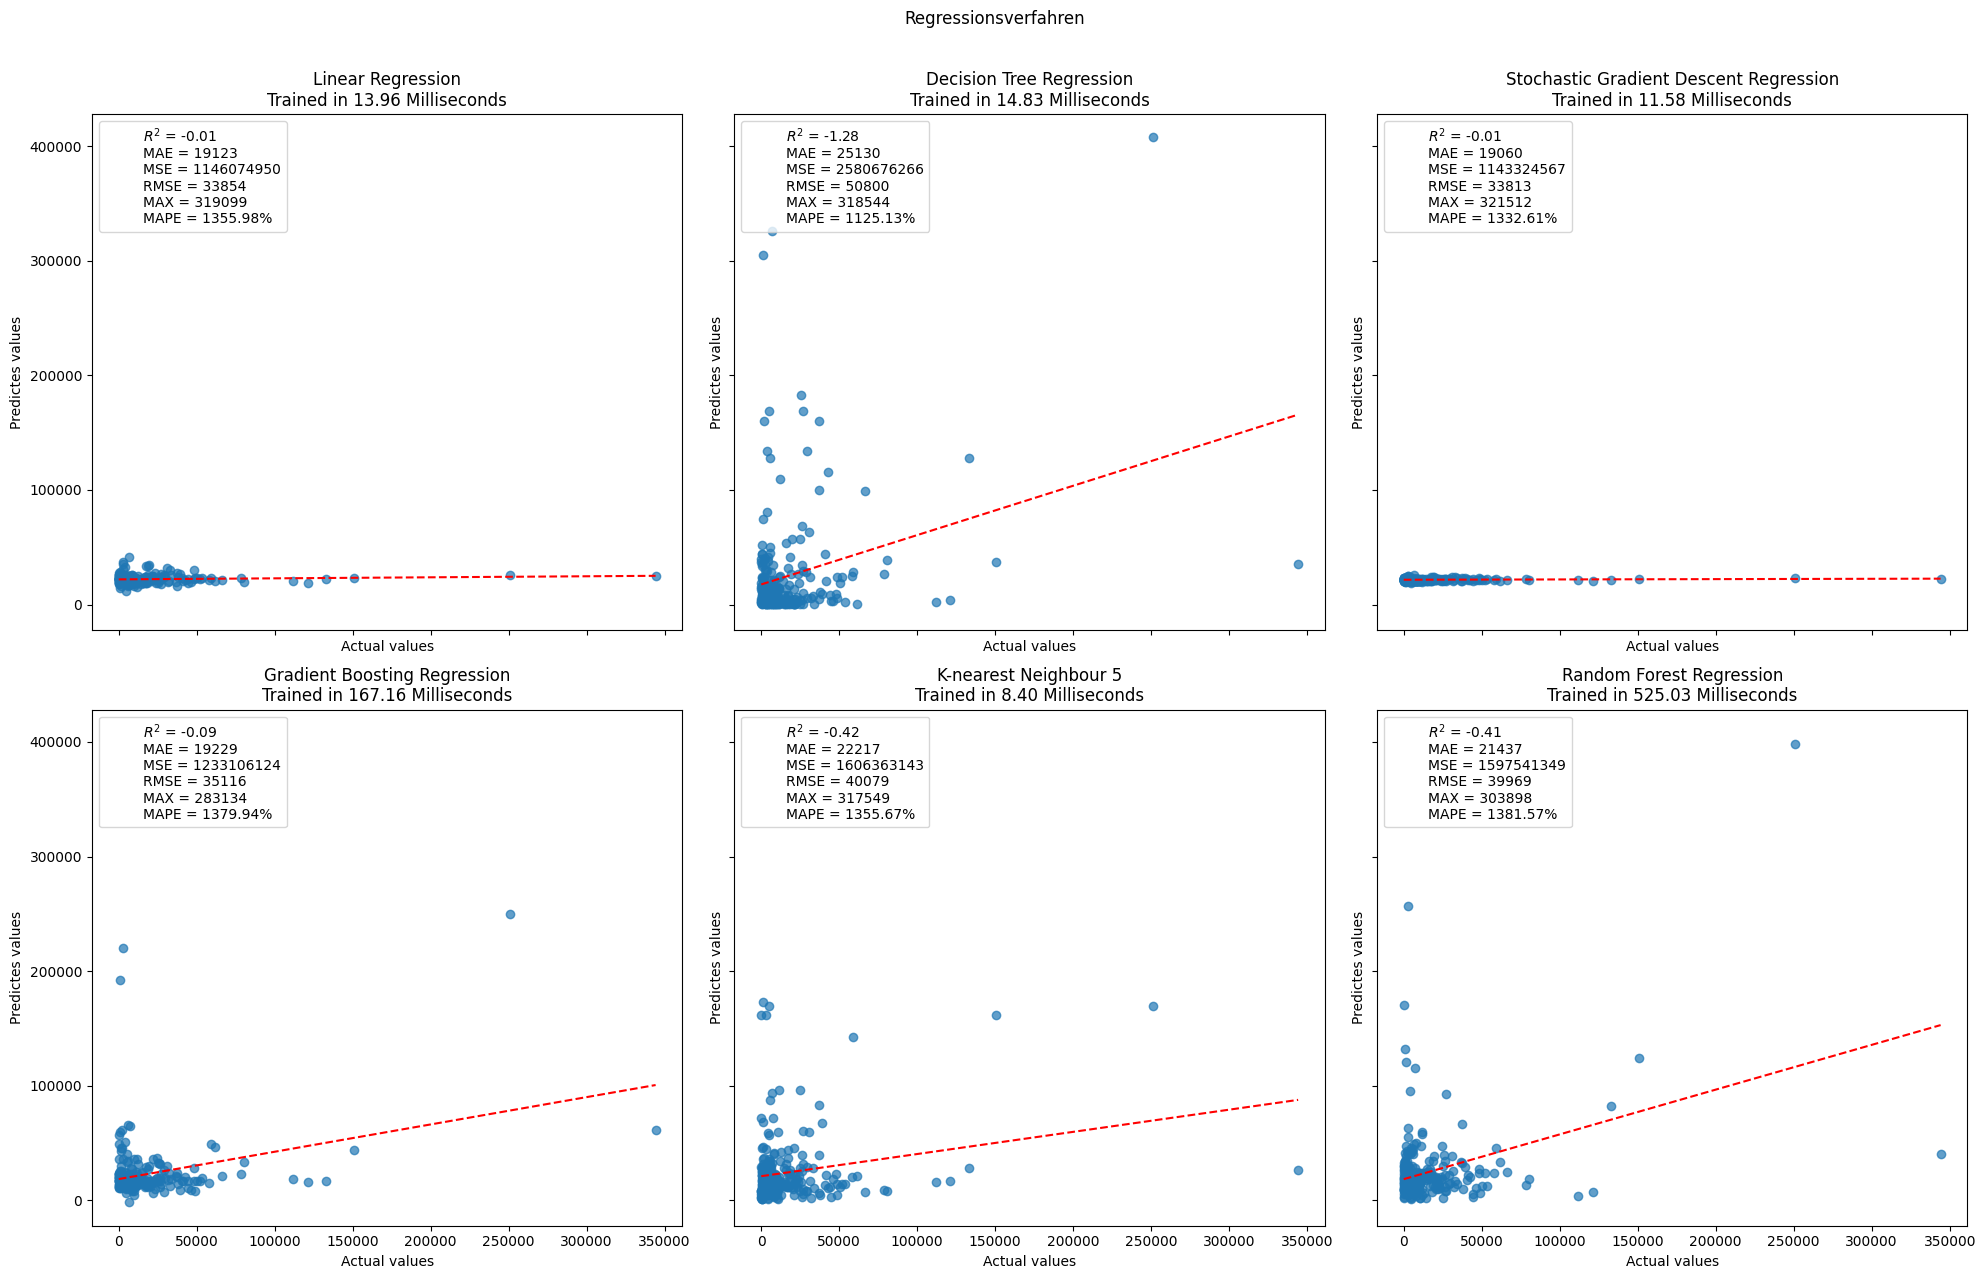

KeyError: 'Tonnage'

In [ ]:
# Load your dataset
train2['Tonnage'] = train2['Tonnage_sum']
train2.drop(columns = ['Tonnage_sum'])
traain = train2.copy()
traain = traain.dropna()

# Divide test set into 3 parts: test3_model, test2_eaub, test2_npkb
#test3_model has no nan values, test2_eaub has nan values in 'Qté eau (m3)' and test2_npkb has nan values in 'N', 'P', 'K'
# Each are predicted with a different model

test3_model = test2.copy()
test3_model = test3_model.dropna()

test2_eaub = test2[test2['Qté eau (m3)'].isna() & test2[['N', 'P', 'K']].notna().all(axis=1)]
test2_npkb = test2[test2['Qté eau (m3)'].notna() & test2[['N', 'P', 'K']].isna().all(axis=1)]


columns3_model = ['Qté eau (m3)','N','P','K','year_plantage','sup totale']
columns2_eaub = ['N','P','K','year_plantage','sup totale']
columns2_npkb = ['Qté eau (m3)','year_plantage','sup totale']

L_full = predict(test3_model,columns3_model,[])
L_eau = predict(test2_eaub,columns2_eaub,[])
L_npk = predict(test2_npkb,columns2_npkb,[])


test3_model['Tonnage'] = L_full[4][2]
test2_eaub['Tonnage'] = L_eau[4][2]
test2_npkb['Tonnage'] = L_npk[4][2]

test_submit = test.copy()

test_submit['num'] = test_submit['Site'] + test_submit['Num Parcelle'].astype(str).str.replace(r'(\s|\.0)$', '', regex=True) + test_submit['Variete'].str.replace(' ', '')
test_submit['num'] = test_submit['num'].replace('\.0$', '', regex=True)


test_submit = test_submit.set_index(['Campagne', 'num']).combine_first(test2_npkb.set_index(['Campagne', 'num'])).reset_index()
test_submit = test_submit.set_index(['Campagne', 'num']).combine_first(test2_eaub.set_index(['Campagne', 'num'])).reset_index()
test_submit = test_submit.set_index(['Campagne', 'num']).combine_first(test3_model.set_index(['Campagne', 'num'])).reset_index()

test_submit['Tonnage'] = test_submit['Tonnage'] / 3

test_submit.sort_values(by='Id')

test_submit[['Id','Tonnage']].to_csv('/content/drive/MyDrive/Projet kaggle/submit.csv', index=False)